In [1]:
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 

from src.tools import clean_date, clean_date_and_hour, clear_string, period_of_day

%matplotlib inline

## Create a single dataframe

In [2]:
dfs = []
for year in range(2007, 2018):
    temp_df = pd.read_csv(f'../data/dirty/datatran{year}.csv', sep=';', encoding="latin1", low_memory=False)
    print(temp_df.shape)
    dfs.append(temp_df)

(127675, 26)
(141043, 26)
(158646, 26)
(183469, 26)
(192326, 26)
(184568, 26)
(186748, 26)
(169201, 26)
(122161, 26)
(96363, 25)
(89518, 30)


In [3]:
df = pd.concat(dfs, sort=False)
df = df.reset_index()
df.tail()

,index,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
1651713,89513,133285,2017-09-10,domingo,11:50:00,AL,316,242,ATALAIA ...,Falta de Atenção à Condução ...,...,1,1,0,1,2,-9.508500,-36.017100,SR-AL,DEL13/1,UOP01/AL
1651714,89514,133485,2017-10-18,quarta-feira,17:20:00,PR,277,5,PARANAGUA ...,Falta de Atenção do Pedestre ...,...,0,0,0,2,1,-25.530448,-48.528874,SR-PR,DEL7/1,UOP07/PR
1651715,89515,133723,2017-12-10,domingo,10:05:00,MT,364,"233,5",RONDONOPOLIS ...,Não guardar distância de segurança ...,...,0,1,0,1,1,-16.237127,-54.781826,SR-MT,DEL2/2,UOP01/MT
1651716,89516,133740,2017-02-10,sexta-feira,15:50:00,MG,50,61,ARAGUARI ...,Não guardar distância de segurança ...,...,0,2,1,3,2,-18.810509,-48.246160,SR-MG,DEL4/17,UOP02/MG
1651717,89517,133958,2017-12-20,quarta-feira,05:00:00,PE,408,84,SAO LOURENCO DA MATA ...,Falta de Atenção à Condução ...,...,0,0,0,2,1,-7.958815,-35.097381,SR-PE,DEL11/1,UOP01/PE


In [4]:
df.shape

(1651718, 32)

Removing features that are not in all datasets

In [5]:
df = df.drop(['latitude', 'longitude', 'regional', 'delegacia', 'uop'], axis=1)
df.shape

(1651718, 27)

# Fix dates

In [6]:
df['date'] = df.data_inversa.apply(clean_date)

In [7]:
df['datetime'] = df.apply(lambda row: clean_date_and_hour(row['data_inversa'], row['horario']), axis=1)

In [8]:
df['year'] = df.datetime.apply(lambda x: x.year)
df.year.value_counts()

2011    192326
2013    186748
2012    184568
2010    183469
2014    169201
2009    158646
2008    141043
2007    127675
2015    122161
2016     96363
2017     89518
Name: year, dtype: int64

In [9]:
df.drop(['ano'], axis=1, inplace=True)

In [10]:
df['day'] = df.datetime.apply(lambda x: x.day)

In [11]:
df['month'] = df.datetime.apply(lambda x: x.month)


In [12]:
df.drop(['data_inversa', 'horario'], axis=1, inplace=True)

In [13]:
df.head()

,index,id,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,date,datetime,year,day,month
0,0,10,Segunda,MG,381,623.2,OLIVEIRA,Falta de atenção,Colisão frontal,(null),...,0,5,0,4,6,2007-06-11,2007-06-11 15:30:00,2007,11,6
1,1,10,Segunda,MG,381,623.2,OLIVEIRA,Falta de atenção,Colisão frontal,(null),...,0,5,0,4,6,2007-06-11,2007-06-11 15:30:00,2007,11,6
2,2,1032898,Segunda,MG,40,585.5,ITABIRITO,Outras,Saída de Pista,Com Vítimas Feridas,...,1,2,0,1,1,2007-08-13,2007-08-13 14:25:00,2007,13,8
3,3,1051130,Segunda,MA,135,11,SAO LUIS,Animais na Pista,Atropelamento de animal,Com Vítimas Fatais,...,1,0,0,3,1,2007-02-12,2007-02-12 02:10:00,2007,12,2
4,4,1066824,Terça,CE,222,30.8,CAUCAIA,Defeito mecânico em veículo,Capotamento,Com Vítimas Feridas,...,0,0,0,1,1,2007-11-20,2007-11-20 05:30:00,2007,20,11


# Removing lines that doesn't have our target variable

In [14]:
df.classificacao_acidente.value_counts(dropna=False)

Sem Vítimas            937965
Com Vítimas Feridas    634033
Com Vítimas Fatais      68034
Ignorado                11660
(null)                     25
NaN                         1
Name: classificacao_acidente, dtype: int64

In [15]:
print(df.shape)
df = df[~df.classificacao_acidente.isin(['(null)', 'Ignorado', np.nan])]
print(df.shape)

(1651718, 29)
(1640032, 29)


# Fixing columns 

In [16]:
for col in df.columns:
    if col == 'br' or col == 'km':
        continue
    if df[col].dtype == object:
        df[col] = df[col].apply(clear_string)

In [17]:
df = df.replace('nan', np.nan)

In [18]:
def create_target(value):
    if value == 'sem vitimas':
        return 0
    if value == 'com vitimas feridas':
        return 1
    return 2

df['target'] = df.classificacao_acidente.apply(create_target)
df.drop(['classificacao_acidente'], axis=1, inplace=True)

In [19]:
df.columns

Index(['index', 'id', 'dia_semana', 'uf', 'br', 'km', 'municipio',
       'causa_acidente', 'tipo_acidente', 'fase_dia', 'sentido_via',
       'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo',
       'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos',
       'ignorados', 'feridos', 'veiculos', 'date', 'datetime', 'year', 'day',
       'month', 'target'],
      dtype='object')

# Translating and simplifing Accident causes

In [20]:
accident_causes = {
    'falta de atencao': 'lack of attention',
    'outras': 'other',
    'nao guardar distancia de seguranca': 'not keeping safety distance',
    'velocidade incompativel': 'unsuitable speed',
    'desobediencia a sinalizacao': 'disobedience to signaling',
    'defeito mecanico em veiculo': 'mechanical defect',
    'ingestao de alcool': 'alcohol intake', 
    'animais na pista': 'animals on the road',
    'dormindo': 'fell asleep',
    'ultrapassagem indevida': 'improper overshoot',
    'falta de atencao a conducao': 'lack of attention',
    'defeito na via': 'road defect',
    'velocidade incompativel': 'unsuitable speed',
    'ingestao de alcool': 'alcohol intake',
    'nao guardar distancia de seguranca': 'not keeping safety distance',
    'desobediencia as normas de transito pelo condutor': 'disobedience to the rules of transit',
    'defeito mecanico no veiculo': 'mechanical defect',
    'pista escorregadia': 'slippery road',
    'condutor dormindo': 'fell asleep',
    'animais na pista': 'animals on the road',
    'falta de atencao do pedestre': 'lack of attention of the pedestrian',
    'ultrapassagem indevida': 'improper overshoot',
    'avarias e/ou desgaste excessivo no pneu': 'tire problems',
    'defeito na via': 'road defect',
    'mal subito': 'sudden onset',
    'restricao de visibilidade': 'low visibility',
    'objeto estatico sobre o leito carrocavel': 'static object on the carabiner bed',
    'carga excessiva e/ou mal acondicionada': 'excessive cargo',
    'fenomenos da natureza': 'nature phenomena',
    'sinalizacao da via insuficiente ou inadequada': 'unsufficient signalization',
    'deficiencia ou nao acionamento do sistema de iluminacao/sinalizacao do veiculo': 'vehicule illumination defect',
    'ingestao de substancias psicoativas': 'drug intake',
    'agressao externa': 'external agression',
    '(null)': 'other',
}

df['accident_causes'] = df.causa_acidente.apply(lambda x: accident_causes[x.strip()])
df.accident_causes.value_counts()

lack of attention                       540392
other                                   444980
not keeping safety distance             145724
unsuitable speed                        142178
mechanical defect                        67289
alcohol intake                           67285
disobedience to signaling                63567
fell asleep                              44415
animals on the road                      44253
improper overshoot                       37260
road defect                              24913
disobedience to the rules of transit      5216
slippery road                             4248
lack of attention of the pedestrian       2389
tire problems                             1587
sudden onset                               969
low visibility                             884
static object on the carabiner bed         770
excessive cargo                            545
nature phenomena                           442
unsufficient signalization                 412
vehicule illu

In [21]:
accident_causes_simplified = {
    'falta de atencao': 'driver_issue',
    'outras': 'other',
    'nao guardar distancia de seguranca': 'driver_issue',
    'velocidade incompativel': 'driver_issue',
    'desobediencia a sinalizacao': 'driver_issue',
    'defeito mecanico em veiculo': 'car_issue',
    'ingestao de alcool': 'driver_issue', 
    'animais na pista': 'road_issue',
    'dormindo': 'driver_issue',
    'ultrapassagem indevida': 'driver_issue',
    'falta de atencao a conducao': 'driver_issue',
    'defeito na via': 'road_issue',
    'velocidade incompativel': 'driver_issue',
    'ingestao de alcool': 'driver_issue',
    'nao guardar distancia de seguranca': 'driver_issue',
    'desobediencia as normas de transito pelo condutor': 'driver_issue',
    'defeito mecanico no veiculo': 'car_issue',
    'pista escorregadia': 'road_issue',
    'condutor dormindo': 'driver_issue',
    'animais na pista': 'road_issue',
    'falta de atencao do pedestre': 'road_issue',
    'ultrapassagem indevida': 'driver_issue',
    'avarias e/ou desgaste excessivo no pneu': 'car_issue',
    'defeito na via': 'road_issue',
    'mal subito': 'driver_issue',
    'restricao de visibilidade': 'road_issue',
    'objeto estatico sobre o leito carrocavel': 'car_issue',
    'carga excessiva e/ou mal acondicionada': 'car_issue',
    'fenomenos da natureza': 'road_issue',
    'sinalizacao da via insuficiente ou inadequada': 'road_issue',
    'deficiencia ou nao acionamento do sistema de iluminacao/sinalizacao do veiculo': 'car_issue',
    'ingestao de substancias psicoativas': 'driver_issue',
    'agressao externa': 'other',
    '(null)': 'other',
}

df['accident_causes_simplified'] = df.causa_acidente.apply(lambda x: accident_causes_simplified[x.strip()])
df.accident_causes_simplified.value_counts()

driver_issue    1047084
other            444982
road_issue        77541
car_issue         70425
Name: accident_causes_simplified, dtype: int64

In [22]:
df.drop(['causa_acidente'], axis=1, inplace=True)

# Translating and simplifing Accident Types

In [23]:
accident_types = {
    'colisao traseira': 'rear collision', 
    'colisao lateral': 'lateral collision', 
    'saida de pista': 'out of road',
    'colisao transversal': 'transversal collision', 
    'colisao com objeto fixo': 'collision', 
    'capotamento': 'rollover',
    'tombamento': 'tipping', 
    'colisao frontal': 'front collision',
    'queda de motocicleta / bicicleta / veiculo': 'vehicle fall',
    'atropelamento de pessoa': 'people trampling', 
    'atropelamento de animal': 'animal trampling',
    'colisao com bicicleta': 'collision with bike',
    'saida de leito carrocavel': 'carriage bed outlet',
    'colisao com objeto movel': 'collision with moving object', 
    'danos eventuais': 'eventual damage',
    'derramamento de carga': 'cargo spill', 
    'incendio': 'fire', 
    'colisao com objeto estatico': 'collision',
    'atropelamento de pedestre': 'people trampling',
    'queda de ocupante de veiculo': 'vehicle occupant fall',
    'engavetamento': 'pestle', 
    'colisao com objeto em movimento': 'collision with moving object',
}

df['accident_types'] = df.tipo_acidente.apply(lambda x: accident_types[x.strip()])
df.accident_types.value_counts()

rear collision                  449861
lateral collision               264406
out of road                     228109
transversal collision           166603
collision                        99222
rollover                         79895
tipping                          69487
front collision                  63324
vehicle fall                     52019
people trampling                 47477
animal trampling                 38040
collision with bike              18518
carriage bed outlet              15673
collision with moving object     15494
eventual damage                   9963
cargo spill                       8960
fire                              8172
vehicle occupant fall             3615
pestle                            1194
Name: accident_types, dtype: int64

In [24]:
accident_types_simplified = {
    'colisao traseira': 'collision', 
    'colisao lateral': 'collision', 
    'saida de pista': 'out of road',
    'colisao transversal': 'collision', 
    'colisao com objeto fixo': 'collision', 
    'capotamento': 'rollover',
    'tombamento': 'tipping', 
    'colisao frontal': 'collision',
    'queda de motocicleta / bicicleta / veiculo': 'vehicle fall',
    'atropelamento de pessoa': 'trampling', 
    'atropelamento de animal': 'trampling',
    'colisao com bicicleta': 'collision',
    'saida de leito carrocavel': 'carriage bed outlet',
    'colisao com objeto movel': 'collision', 
    'danos eventuais': 'eventual damage',
    'derramamento de carga': 'cargo spill', 
    'incendio': 'fire', 
    'colisao com objeto estatico': 'collision',
    'atropelamento de pedestre': 'trampling',
    'queda de ocupante de veiculo': 'vehicle occupant fall',
    'engavetamento': 'pestle', 
    'colisao com objeto em movimento': 'collision',
}

df['accident_types_simplified'] = df.tipo_acidente.apply(
    lambda x: accident_types_simplified[x.strip()]
)
df.accident_types_simplified.value_counts()

collision                1077428
out of road               228109
trampling                  85517
rollover                   79895
tipping                    69487
vehicle fall               52019
carriage bed outlet        15673
eventual damage             9963
cargo spill                 8960
fire                        8172
vehicle occupant fall       3615
pestle                      1194
Name: accident_types_simplified, dtype: int64

In [25]:
df.drop(['tipo_acidente'], axis=1, inplace=True)

# Extracting date information

Using datetime.weekday function we have Monday as 0 and Sunday as 6

In [26]:
df['weekday'] = df.datetime.apply(lambda x: x.weekday())
df.weekday.value_counts()

4    266825
5    255703
6    242756
0    225939
3    224989
2    215396
1    208424
Name: weekday, dtype: int64

In [27]:
df.drop(['dia_semana'], axis=1, inplace=True)

In [28]:
df['hour'] = df.datetime.apply(lambda x: x.hour)

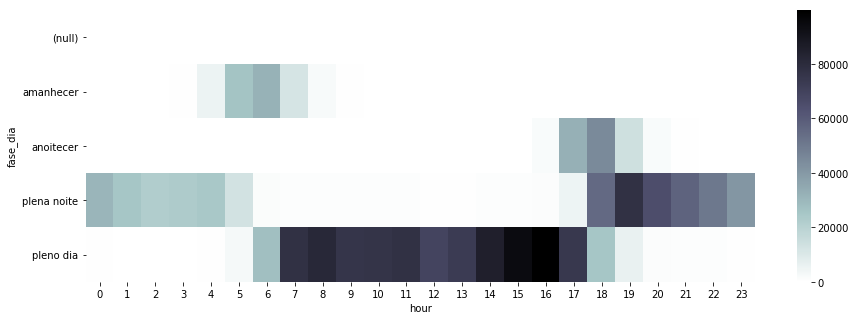

In [29]:
grouped = df.groupby(['fase_dia', 'hour']).size().unstack()

plt.figure(figsize=(15,5))
sns.heatmap(grouped, cmap='bone_r')

In [30]:
df['period_of_day'] = df.hour.apply(period_of_day)
df.drop(['fase_dia'], axis=1, inplace=True)

# Cleaning road characteristics

In [31]:
df.sentido_via.value_counts()

crescente        840239
decrescente      799647
nao informado       146
Name: sentido_via, dtype: int64

In [32]:
direction_translation = {
    'crescente': 'crescent',
    'decrescente': 'decrescent',
    'nao informado': 'not informed',
}

df['road_direction'] = df.sentido_via.apply(lambda x: direction_translation[x])
df.drop(['sentido_via'], axis=1, inplace=True)

In [33]:
df.tipo_pista.value_counts(dropna=False)

simples     858901
dupla       657750
multipla    123371
(null)          10
Name: tipo_pista, dtype: int64

### remove where we don't know the type of road 

In [34]:
df = df[df.tipo_pista != '(null)']

In [35]:
type_of_road_translation = {
    'simples': 'simple',
    'dupla': 'double',
    'multipla': 'multiple'
}

df['type_of_road'] = df.tipo_pista.apply(lambda x: type_of_road_translation[x])
df.drop(['tipo_pista'], axis=1, inplace=True)

In [36]:
df.tracado_via.value_counts(dropna=False)

reta                     1168329
curva                     351599
cruzamento                101521
nao informado               8117
intersecao de vias          3815
desvio temporario           2507
rotatoria                   1864
retorno regulamentado       1000
viaduto                      654
ponte                        533
tunel                         83
Name: tracado_via, dtype: int64

In [37]:
road_layout_translation = {
    'reta': 'straight', 
    'curva': 'curve', 
    'cruzamento': 'crossroad', 
    'nao informado': 'unknown', 
    'intersecao de vias': 'road intersection',
    'desvio temporario': 'temporary detour', 
    'rotatoria': 'roundabout', 
    'retorno regulamentado': 'return', 
    'viaduto': 'viaduct',
    'ponte': 'bridge', 
    'tunel': 'tunnel',
}

df['road_layout'] = df.tracado_via.apply(lambda x: road_layout_translation[x])
df.drop(['tracado_via'], axis=1, inplace=True)

In [38]:
road_layout_simplified = {
    'straight': 'straight', 
    'curve': 'curve', 
    'crossroad': 'crossroad', 
    'unknown': 'unknown', 
    'road intersection': 'other',
    'temporary detour': 'other', 
    'roundabout': 'other', 
    'return': 'other', 
    'viaduct': 'other',
    'bridge': 'other', 
    'tunnel': 'other',
}
df['road_layout_simplified'] = df.road_layout.apply(lambda x: road_layout_simplified[x])
df['road_layout_simplified'].value_counts()

straight     1168329
curve         351599
crossroad     101521
other          10456
unknown         8117
Name: road_layout_simplified, dtype: int64

In [39]:
df.uso_solo.value_counts()

urbano    809425
rural     741079
nao        52838
sim        36680
Name: uso_solo, dtype: int64

In [40]:
df.drop(['uso_solo'], axis=1, inplace=True)

# Cleaning weather

In [41]:
df.condicao_metereologica.value_counts()

ceu claro           795378
nublado             297002
chuva               282520
sol                 210881
ignorada             27840
nevoeiro/neblina     16883
vento                 4439
garoa/chuvisco        3141
ignorado              1480
granizo                292
neve                   105
(null)                  58
Name: condicao_metereologica, dtype: int64

In [42]:
weather_translation = {
    'ceu claro': 'clear sky', 
    'nublado': 'cloudy', 
    'chuva': 'rain', 
    'sol': 'sun', 
    'ignorada': 'unknown', 
    'nevoeiro/neblina': 'foggy',
    'vento': 'windy', 
    'garoa/chuvisco': 'drizzle', 
    'ignorado': 'unknown', 
    'granizo': 'hail', 
    'neve': 'snow', 
    '(null)': 'unknown',
}

df['weather'] = df.condicao_metereologica.fillna('(null)').apply(lambda x: weather_translation[x])
df.drop(['condicao_metereologica'], axis=1, inplace=True)

In [43]:
df.weather.value_counts()

clear sky    795378
cloudy       297002
rain         282520
sun          210881
unknown       29381
foggy         16883
windy          4439
drizzle        3141
hail            292
snow            105
Name: weather, dtype: int64

In [44]:
weather_simplified = {
    'clear sky': 'clear sky', 
    'cloudy': 'cloudy', 
    'rain': 'rain', 
    'sun': 'clear sky', 
    'unknown': 'unknown', 
    'foggy': 'bad weather', 
    'windy': 'windy',
    'drizzle': 'bad weather', 
    'hail': 'bad weather', 
    'snow': 'bad weather',
}

df['weather_simplified'] = df.weather.apply(lambda x: weather_simplified[x])

In [45]:
df.weather_simplified.value_counts()

clear sky      1006259
cloudy          297002
rain            282520
unknown          29381
bad weather      20421
windy             4439
Name: weather_simplified, dtype: int64

# Cleaning / renaming numerical variables

In [49]:
df.rename(columns={
    'municipio': 'county',
    'pessoas': 'num_of_people',
    'mortos': 'deceased',
    'feridos_leves': 'mild_injured',
    'feridos_graves': 'severe_injured',
    'ilesos': 'unharmed',
    'feridos': 'injured',
    'veiculos': 'num_of_vehicles',
}, inplace=True)

In [51]:
df.drop(['ignorados'], axis=1, inplace=True)

In [52]:
df.columns

Index(['index', 'id', 'uf', 'br', 'km', 'county', 'num_of_people', 'deceased',
       'mild_injured', 'severe_injured', 'unharmed', 'injured',
       'num_of_vehicles', 'date', 'datetime', 'year', 'day', 'month', 'target',
       'accident_causes', 'accident_causes_simplified', 'accident_types',
       'accident_types_simplified', 'weekday', 'hour', 'period_of_day',
       'road_direction', 'type_of_road', 'road_layout',
       'road_layout_simplified', 'weather', 'weather_simplified'],
      dtype='object')

# Saving cleaned dataset

In [53]:
df.to_csv('../data/clean/car_accidents.csv', index=False)